# FedPer Implementation with Flower Framework

## Overview

This notebook demonstrates the implementation of **FedPer (Federated Personalization)** using the [Flower](https://flower.dev/) federated learning framework. FedPer is a federated learning algorithm that balances between global knowledge sharing and local personalization by splitting the neural network into shared and personalized layers.

## FedPer Algorithm

FedPer addresses the challenge of statistical heterogeneity in federated learning by:

- **Shared Layers**: Lower layers of the network that capture general features are shared across all clients through federated averaging
- **Personalized Layers**: Upper layers that are kept local to each client to capture client-specific patterns
- **Hybrid Training**: Only shared parameters are aggregated globally, while personalized parameters remain local

This approach allows clients to benefit from global knowledge while maintaining personalization for their specific data distributions.

## Experimental Setup

### Dataset
- **CIFAR-10**: 10-class image classification dataset with 50,000 training and 10,000 test images

### Data Distribution Strategies
We evaluate FedPer under three different data distribution scenarios:

1. **IID (Independent and Identically Distributed)**: Data is randomly and uniformly distributed across clients
2. **Non-IID (Dirichlet)**: Data distribution follows a Dirichlet distribution (α=0.5) creating statistical heterogeneity
3. **Non-IID (Shard)**: Each client receives data from only a limited number of classes (label quantity partitioning)

### Architecture
- **Shared Layers**: Convolutional layers for feature extraction
- **Personalized Layers**: Fully connected classifier layers
- **Model**: Custom CNN with dropout and batch normalization

### Federated Learning Configuration
- **Total Clients**: 10
- **Clients per Round**: 10 (100% participation)
- **Communication Rounds**: 10
- **Local Epochs**: 10
- **Batch Size**: 64
- **Learning Rate**: 0.01

## Key Features

- Custom Flower strategy implementation for FedPer
- Support for multiple data partitioning strategies
- Comprehensive evaluation on local validation sets
- Results logging and comparison across different data distributions

## Expected Outcomes

The experiment aims to demonstrate how FedPer performs under different data heterogeneity conditions, showing its effectiveness in maintaining good performance while allowing for client personalization.

# Constants

In [ ]:
TOTAL_CLIENTS = 10      # Number of clients
CLIENTS_PER_ROUND = 10  # Number of clients per round Equal to C = 1
ROUNDS = 10             # Number of rounds
LOCAL_EPOCHS = 10       # Number of local epochs
BATCH_SIZE = 64         # Batch size
PARTITION_SEED = 42     # Seed for partitioning the dataset
LR = 0.01               # Learning rate
LABELS_PER_CLIENT = 2   # Number of labels per client - Only for shard data partitioning (partition_data_label_quantity)


# Imports

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torchvision import transforms
from torchvision.datasets import CIFAR10

import numpy as np
import random
import csv
from collections import OrderedDict
from pathlib import Path
from typing import List, Tuple, Dict, Optional, Union

# Flower specific
import flwr as fl
from flwr.client import NumPyClient, Client, ClientApp
from flwr.server.client_manager import ClientManager
from flwr.server.client_proxy import ClientProxy
from flwr.server.strategy import Strategy
from flwr.server.strategy.aggregate import aggregate, weighted_loss_avg
from flwr.server import ServerAppComponents, ServerConfig, ServerApp
from flwr.simulation import run_simulation
from flwr.common import (
    FitIns,
    FitRes,
    EvaluateIns,
    EvaluateRes,
    Parameters,
    Scalar,
    Context,
    ndarrays_to_parameters,
    parameters_to_ndarrays,
)
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu' # Device to use for training

2025-06-24 13:31:14.694942: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Downloading and partitioning data

In [3]:
def load_cifar10():
    transform_train = transforms.Compose([
        transforms.ToTensor(),
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
    ])
    transform_test = transforms.ToTensor()
    trainset = CIFAR10(root="data", train=True, download=True, transform=transform_train)
    testset = CIFAR10(root="data", train=False, download=True, transform=transform_test)
    return trainset, testset

def partition_iid(trainset, num_clients, seed=42):
    np.random.seed(seed)
    indices = np.random.permutation(len(trainset))
    return [Subset(trainset, idx) for idx in np.array_split(indices, num_clients)]

def partition_dirichlet(trainset, num_clients, alpha=0.5, seed=42):
    np.random.seed(seed)
    labels = np.array(trainset.targets)
    num_classes = 10
    idx_clients = [[] for _ in range(num_clients)]

    for c in range(num_classes):
        idx_c = np.where(labels == c)[0]
        np.random.shuffle(idx_c)
        proportions = np.random.dirichlet(np.repeat(alpha, num_clients))
        proportions = (np.cumsum(proportions) * len(idx_c)).astype(int)[:-1]
        split = np.split(idx_c, proportions)
        for i, idx in enumerate(split):
            idx_clients[i].extend(idx)
    return [Subset(trainset, idxs) for idxs in idx_clients]

def partition_label_quantity(trainset, num_clients, labels_per_client=2, seed=42):
    np.random.seed(seed)
    labels = np.array(trainset.targets)
    num_classes = 10
    class_idxs = {i: np.where(labels == i)[0] for i in range(num_classes)}
    client_data = [[] for _ in range(num_clients)]

    for client_id in range(num_clients):
        chosen_labels = np.random.choice(num_classes, labels_per_client, replace=False)
        for label in chosen_labels:
            n_samples = len(class_idxs[label]) // num_clients
            chosen_idx = class_idxs[label][:n_samples]
            client_data[client_id].extend(chosen_idx)
            class_idxs[label] = class_idxs[label][n_samples:]
    return [Subset(trainset, idxs) for idxs in client_data]

def load_datasets(partition_id, num_partitions, partition_strategy="iid"):
    # Load the full CIFAR-10 dataset
    trainset, testset = load_cifar10()

    if partition_strategy == "iid":
        partitions = partition_iid(trainset, num_partitions, seed=PARTITION_SEED)
    elif partition_strategy == "dirichlet":
        partitions = partition_dirichlet(trainset, num_partitions, seed=PARTITION_SEED)
    elif partition_strategy == "shard":
        partitions = partition_label_quantity(trainset, num_partitions, labels_per_client=LABELS_PER_CLIENT, seed=PARTITION_SEED)
    else:
        raise ValueError(f"Unknown partition strategy: {partition_strategy}")

    client_subset = partitions[partition_id]

    # Split client subset into train and validation (e.g., 80/20 split)
    num_samples = len(client_subset)
    indices = np.arange(num_samples)
    np.random.shuffle(indices)

    split = int(0.8 * num_samples)
    train_indices, val_indices = indices[:split], indices[split:]

    trainloader = DataLoader(Subset(client_subset, train_indices), batch_size=BATCH_SIZE, shuffle=True)
    valloader = DataLoader(Subset(client_subset, val_indices), batch_size=BATCH_SIZE, shuffle=False)
    testloader = DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False)

    return trainloader, valloader, testloader

## Visualising the data distributions


Visualizing IID distribution
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


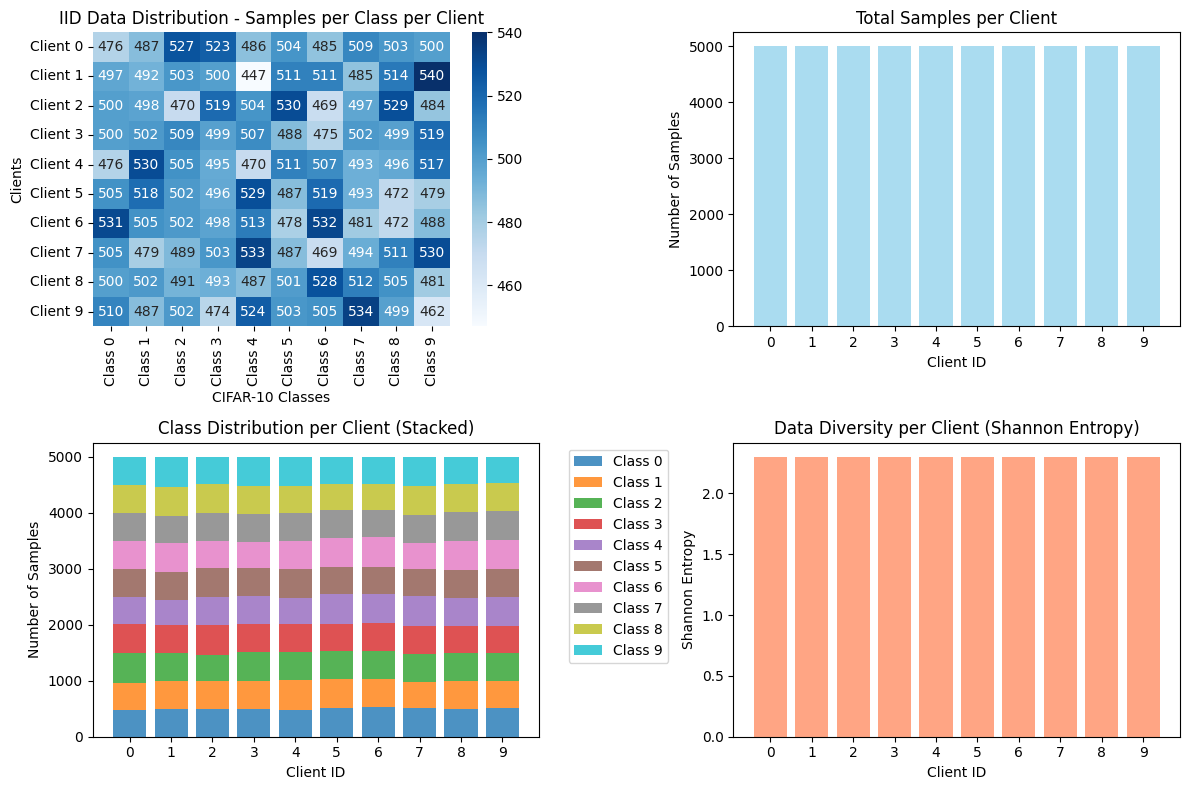


IID Data Distribution Summary:
Total samples: 50000
Average samples per client: 5000.0 ± 0.0
Average entropy per client: 2.302 ± 0.000
Max entropy (uniform): 2.303

Visualizing DIRICHLET distribution
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


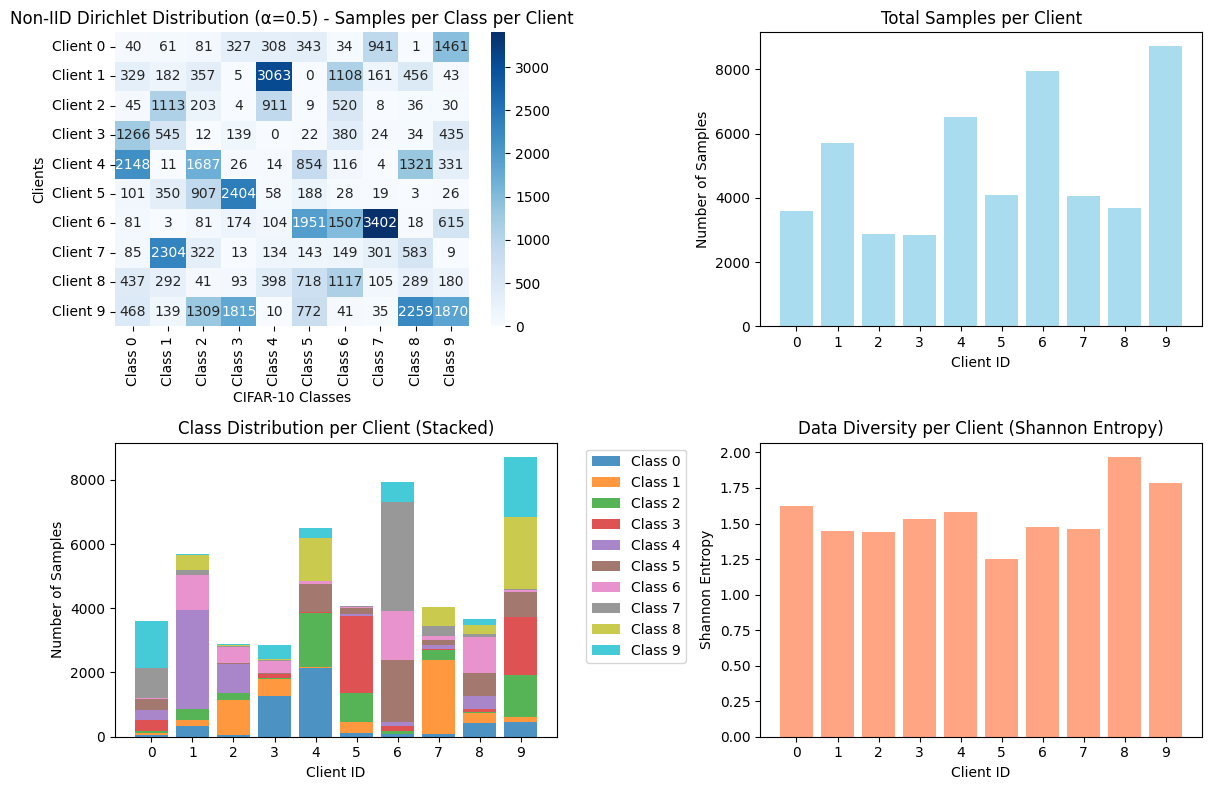


Non-IID Dirichlet Distribution (α=0.5) Summary:
Total samples: 50000
Average samples per client: 5000.0 ± 1995.2
Average entropy per client: 1.555 ± 0.191
Max entropy (uniform): 2.303
Dirichlet α parameter: 0.5 (lower α = more heterogeneous)

Visualizing SHARD distribution
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


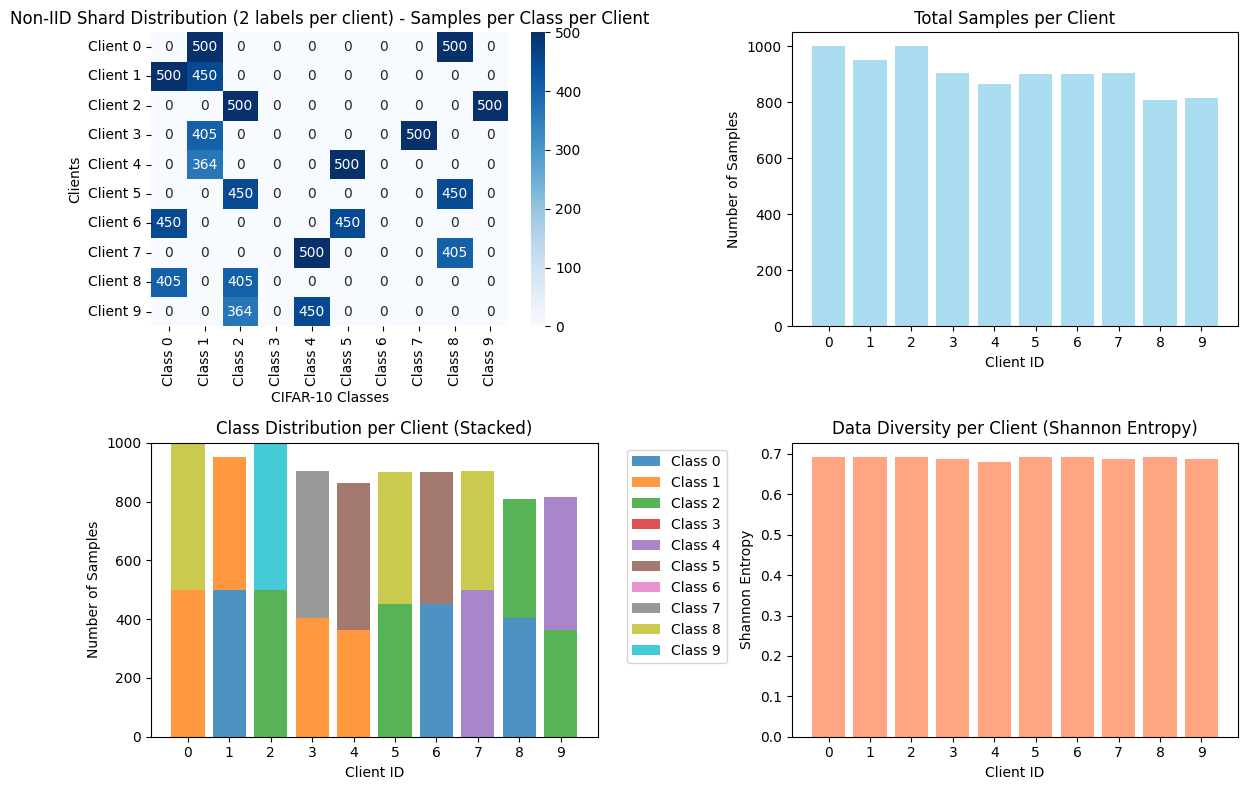


Non-IID Shard Distribution (2 labels per client) Summary:
Total samples: 9048
Average samples per client: 904.8 ± 62.5
Average entropy per client: 0.690 ± 0.004
Max entropy (uniform): 2.303
Labels per client: 2
Classes appearing in multiple clients: 2.0 clients on average


In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

def visualize_data_distribution(partition_strategy: str, num_clients: int = TOTAL_CLIENTS):
    """Visualize the label distribution across clients for a given partitioning strategy."""
    
    # Get the full dataset to analyze distributions
    trainset, _ = load_cifar10()
    
    # Get partitions based on strategy
    if partition_strategy == "iid":
        partitions = partition_iid(trainset, num_clients, seed=PARTITION_SEED)
        title = "IID Data Distribution"
    elif partition_strategy == "dirichlet":
        partitions = partition_dirichlet(trainset, num_clients, seed=PARTITION_SEED)
        title = "Non-IID Dirichlet Distribution (α=0.5)"
    elif partition_strategy == "shard":
        partitions = partition_label_quantity(trainset, num_clients, labels_per_client=LABELS_PER_CLIENT, seed=PARTITION_SEED)
        title = f"Non-IID Shard Distribution ({LABELS_PER_CLIENT} labels per client)"
    else:
        raise ValueError(f"Unknown partition strategy: {partition_strategy}")
    
    # Create distribution matrix
    class_counts = np.zeros((num_clients, 10))  # 10 classes in CIFAR-10
    
    for client_id, partition in enumerate(partitions):
        # Get labels for this client's data
        client_labels = [trainset.targets[idx] for idx in partition.indices]
        label_counts = Counter(client_labels)
        
        for label, count in label_counts.items():
            class_counts[client_id, label] = count
    
    # Create visualization
    plt.figure(figsize=(12, 8))
    
    # Heatmap showing distribution
    plt.subplot(2, 2, 1)
    sns.heatmap(class_counts, annot=True, fmt='.0f', cmap='Blues', 
                xticklabels=[f'Class {i}' for i in range(10)],
                yticklabels=[f'Client {i}' for i in range(num_clients)])
    plt.title(f'{title} - Samples per Class per Client')
    plt.xlabel('CIFAR-10 Classes')
    plt.ylabel('Clients')
    
    # Bar plot showing total samples per client
    plt.subplot(2, 2, 2)
    total_samples = class_counts.sum(axis=1)
    plt.bar(range(num_clients), total_samples, color='skyblue', alpha=0.7)
    plt.title('Total Samples per Client')
    plt.xlabel('Client ID')
    plt.ylabel('Number of Samples')
    plt.xticks(range(num_clients))
    
    # Stacked bar chart showing class distribution per client
    plt.subplot(2, 2, 3)
    bottom = np.zeros(num_clients)
    colors = plt.cm.tab10(np.linspace(0, 1, 10))
    
    for class_id in range(10):
        plt.bar(range(num_clients), class_counts[:, class_id], 
                bottom=bottom, label=f'Class {class_id}', 
                color=colors[class_id], alpha=0.8)
        bottom += class_counts[:, class_id]
    
    plt.title('Class Distribution per Client (Stacked)')
    plt.xlabel('Client ID')
    plt.ylabel('Number of Samples')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.xticks(range(num_clients))
    
    # Shannon entropy plot to show diversity
    plt.subplot(2, 2, 4)
    entropies = []
    for client_id in range(num_clients):
        client_dist = class_counts[client_id]
        if client_dist.sum() > 0:
            client_dist = client_dist / client_dist.sum()  # Normalize to probabilities
            # Calculate Shannon entropy (diversity measure)
            entropy = -np.sum(client_dist * np.log(client_dist + 1e-10))  # Add small value to avoid log(0)
            entropies.append(entropy)
        else:
            entropies.append(0)
    
    plt.bar(range(num_clients), entropies, color='coral', alpha=0.7)
    plt.title('Data Diversity per Client (Shannon Entropy)')
    plt.xlabel('Client ID')
    plt.ylabel('Shannon Entropy')
    plt.xticks(range(num_clients))
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print(f"\n{title} Summary:")
    print(f"Total samples: {class_counts.sum():.0f}")
    print(f"Average samples per client: {total_samples.mean():.1f} ± {total_samples.std():.1f}")
    print(f"Average entropy per client: {np.mean(entropies):.3f} ± {np.std(entropies):.3f}")
    print(f"Max entropy (uniform): {np.log(10):.3f}")
    
    return class_counts, entropies

# Visualize all three distribution strategies
strategies = ["iid", "dirichlet", "shard"]

for strategy in strategies:
    print(f"\n{'='*60}")
    print(f"Visualizing {strategy.upper()} distribution")
    print(f"{'='*60}")
    
    class_counts, entropies = visualize_data_distribution(strategy)
    
    # Additional analysis
    if strategy == "dirichlet":
        print(f"Dirichlet α parameter: 0.5 (lower α = more heterogeneous)")
    elif strategy == "shard":
        print(f"Labels per client: {LABELS_PER_CLIENT}")
        non_zero_clients = np.sum(class_counts > 0, axis=0)
        print(f"Classes appearing in multiple clients: {np.mean(non_zero_clients):.1f} clients on average")

# FedPer

## Define Neural Net to expose shared/personalised layer handling

In [5]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Shared layers
        self.shared = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.25),
        )

        # Personalized layers
        self.classifier = nn.Sequential(
            nn.Linear(64 * 8 * 8, 256),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.Linear(256, 10)
        )

    def forward(self, x):
        x = self.shared(x)
        x = x.view(-1, 64 * 8 * 8)
        x = self.classifier(x)
        return x

    def get_shared_parameters(self) -> List[np.ndarray]:
        return [val.cpu().numpy() for _, val in self.shared.state_dict().items()]

    def set_shared_parameters(self, parameters: List[np.ndarray]):
        params_dict = zip(self.shared.state_dict().keys(), parameters)
        state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
        self.shared.load_state_dict(state_dict, strict=True)

## Define FlowerClient

In [6]:
def train(net, trainloader, epochs: int):
    """Train the network on the training set."""
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=LR)
    net.train()

    for epoch in range(epochs):
        correct, total, epoch_loss = 0, 0, 0.0
        for images, labels in trainloader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = net(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            total += labels.size(0)
            correct += (torch.max(outputs.data, 1)[1] == labels).sum().item()

        epoch_loss /= len(trainloader)
        epoch_acc = correct / total
        if epoch + 1 % 25 == 0:
            print(f"Epoch {epoch+1}: train loss {epoch_loss:.4f}, accuracy {epoch_acc:.4f}")

def test(net, testloader):
    """Evaluate the network on the entire test set."""
    criterion = torch.nn.CrossEntropyLoss()
    correct, total, loss = 0, 0, 0.0
    net.eval()

    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = net(images)
            loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    loss /= len(testloader)
    accuracy = correct / total
    return loss, accuracy

from collections import OrderedDict

def get_parameters(net) -> List[np.ndarray]:
    return [val.cpu().numpy() for _, val in net.state_dict().items()]

def set_parameters(net, parameters: List[np.ndarray]):
    params_dict = zip(net.state_dict().keys(), parameters)
    state_dict = OrderedDict({k: torch.tensor(v) for k, v in params_dict})
    net.load_state_dict(state_dict, strict=True)


class FlowerClient(NumPyClient):
    def __init__(self, partition_id, net, trainloader, valloader):
        self.partition_id = partition_id
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader

    def get_parameters(self, config):
        print(f"[Client {self.partition_id}] get_shared_parameters")
        return self.net.get_shared_parameters()

    def fit(self, parameters, config):
        print(f"[Client {self.partition_id}] fit (FedPer)")
        self.net.set_shared_parameters(parameters)
        train(self.net, self.trainloader, epochs=LOCAL_EPOCHS)
        return self.net.get_shared_parameters(), len(self.trainloader.dataset), {}

    def evaluate(self, parameters, config):
        print(f"[Client {self.partition_id}] evaluate (FedPer)")
        self.net.set_shared_parameters(parameters)
        loss, accuracy = test(self.net, self.valloader)
        return float(loss), len(self.valloader.dataset), {"accuracy": float(accuracy)}


## Implement FedPer Strategy

In [7]:
class FedPerStrategy(Strategy):
    def __init__(
        self,
        fraction_fit: float = CLIENTS_PER_ROUND / TOTAL_CLIENTS,
        fraction_evaluate: float = 1.0,
        min_fit_clients: int = 2,
        min_evaluate_clients: int = 2,
        min_available_clients: int = 2,
    ):
        super().__init__()
        self.fraction_fit = fraction_fit
        self.fraction_evaluate = fraction_evaluate
        self.min_fit_clients = min_fit_clients
        self.min_evaluate_clients = min_evaluate_clients
        self.min_available_clients = min_available_clients

    def __repr__(self):
        return "FedPerStrategy"

    def initialize_parameters(self, client_manager: ClientManager) -> Parameters:
        net = Net()
        return ndarrays_to_parameters(net.get_shared_parameters())

    def configure_fit(self, server_round, parameters, client_manager):
        sample_size, min_num_clients = self.num_fit_clients(client_manager.num_available())
        clients = client_manager.sample(sample_size, min_num_clients)
        fit_ins = FitIns(parameters, {})  # can add config if needed
        return [(client, fit_ins) for client in clients]

    def aggregate_fit(self, server_round, results, failures):
        weights = [
            (parameters_to_ndarrays(fit_res.parameters), fit_res.num_examples)
            for _, fit_res in results
        ]
        aggregated = ndarrays_to_parameters(aggregate(weights))
        return aggregated, {}

    def configure_evaluate(self, server_round, parameters, client_manager):
        sample_size, min_num_clients = self.num_evaluation_clients(client_manager.num_available())
        clients = client_manager.sample(sample_size, min_num_clients)
        evaluate_ins = EvaluateIns(parameters, {})
        return [(client, evaluate_ins) for client in clients]

    def aggregate_evaluate(self, server_round, results, failures):
        if not results:
            return None, {}

        total_examples = 0
        total_accuracy = 0.0
        total_loss = 0.0

        for _, res in results:
            num_examples = res.num_examples
            accuracy = res.metrics.get("accuracy", 0.0)
            loss = res.loss

            total_examples += num_examples
            total_accuracy += accuracy * num_examples
            total_loss += loss * num_examples

        avg_accuracy = total_accuracy / total_examples
        avg_loss = total_loss / total_examples

        # This will be returned in `history.metrics_distributed` in `run_simulation`
        return avg_loss, {"accuracy": avg_accuracy}

    def evaluate(self, server_round, parameters):
        return None

    def num_fit_clients(self, num_available_clients):
        num_clients = int(num_available_clients * self.fraction_fit)
        return max(num_clients, self.min_fit_clients), self.min_available_clients

    def num_evaluation_clients(self, num_available_clients):
        num_clients = int(num_available_clients * self.fraction_evaluate)
        return max(num_clients, self.min_evaluate_clients), self.min_available_clients


## Define running

In [ ]:
RESULTS_FILE = "results.csv"
import os
def append_results_to_csv(approach: str, accuracy: float, notes: str):
    filename = "results.csv"
    file_exists = os.path.isfile(filename)

    with open(filename, mode="a", newline="") as csv_file:
        writer = csv.writer(csv_file)
        # Write header only if file doesn't exist yet
        if not file_exists:
            writer.writerow(["Approach", "Accuracy (%)", "Notes"])
        writer.writerow([approach, f"{accuracy:.2f}", notes])

def evaluate_on_clients_locally(parameters: Parameters, num_clients: int) -> float:
    accuracies = []

    for client_id in range(num_clients):
        # Load client data
        trainloader, valloader, _ = load_datasets(client_id, num_clients, strategy="iid")

        # Build model and set global parameters
        net = Net().to(DEVICE)
        set_parameters(net, parameters_to_ndarrays(parameters))

        # Evaluate on local val set
        _, acc = test(net, valloader)
        accuracies.append(acc)

    avg_acc = sum(accuracies) / len(accuracies)
    return avg_acc * 100  # Percentage
def main(partition_strategy: str):
    print(f"\nRunning FedPer with partition strategy: {partition_strategy}")

    # Set up context and run simulation
    def client_fn(context: Context) -> Client:
        net = Net().to(DEVICE)
        partition_id = context.node_config["partition-id"]
        trainloader, valloader, _ = load_datasets(
            partition_id, TOTAL_CLIENTS, partition_strategy=partition_strategy
        )
        return FlowerClient(partition_id, net, trainloader, valloader).to_client()


    def server_fn(context: Context) -> ServerAppComponents:
        config = ServerConfig(num_rounds=ROUNDS)
        return ServerAppComponents(
            config=config,
            strategy=FedPerStrategy()
        )
    server = ServerApp(server_fn=server_fn)
    client = ClientApp(client_fn=client_fn)
    history = run_simulation(
        client_app=client,
        server_app=server,
        num_supernodes=TOTAL_CLIENTS,
        backend_config={"num_cpus": 1,
            "num_gpus": 0,},
    )


In [ ]:
for data_split_strategy in ["shard"]:
    main(data_split_strategy)